In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18

In [2]:
# Define the path to the dataset
data_dir = "affectnet"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

In [3]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((48, 48)),  # Resize images to a fixed size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])


In [4]:
# Custom Dataset class to load images and labels
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.dataset = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, label

In [5]:
# Create train and test datasets
train_dataset = CustomDataset(train_dir, transform=transform)
test_dataset = CustomDataset(test_dir, transform=transform)

In [6]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
# Define the emotion categories
emotion_categories = {
    1: "Neutral",
    2: "Happiness",
    3: "Sadness",
    4: "Surprise",
    5: "Afraid",
    6: "Disgusted",
    7: "Angry",
    8: "Contempt"
}

In [8]:
# Define the CNN model
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(EmotionCNN, self).__init__()
        self.resnet = resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [9]:

# Initialize the model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN(num_classes=8).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

c:\users\03aay\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\users\03aay\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader)}")

Epoch [1/10] Loss: 1.7393301037641673
Epoch [2/10] Loss: 1.5161585482025919
Epoch [3/10] Loss: 1.4056479173150622
Epoch [4/10] Loss: 1.3272961686979905
Epoch [5/10] Loss: 1.241829445125603
Epoch [6/10] Loss: 1.1313453986335862
Epoch [7/10] Loss: 0.9863742979673239
Epoch [8/10] Loss: 0.8954892823329339
Epoch [9/10] Loss: 0.7112046786044773
Epoch [10/10] Loss: 0.5873341660207583


In [15]:
# Evaluation on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

Accuracy on test set: 43.35%


In [16]:
# Function to decode emotion labels
def decode_emotion_label(label):
    return emotion_categories[label]

# Example usage of decoding labels
example_label = 1
print(f"Emotion Category for label {example_label}: {decode_emotion_label(example_label)}")

Emotion Category for label 1: Neutral


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [18]:
# Evaluation on the test set
model.eval()
correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [19]:
conf_matrix = confusion_matrix(all_labels, all_predicted)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[106  19  53  37  35  56 118  76]
 [ 16 318  15  27   7  27  14  76]
 [ 38  12 186  18  33  72 119  22]
 [ 38  47  39 177  96  36  44  23]
 [ 14  16  56  69 236  49  52   8]
 [ 14  16  35  20  22 242 116  35]
 [ 30  11  32  12  27  96 268  24]
 [ 50  82  25  17   5  53  67 201]]


In [20]:
# Save the model to an h5 file
torch.save(model.state_dict(), "model1.h5")

In [23]:
import seaborn as sns

<AxesSubplot: >

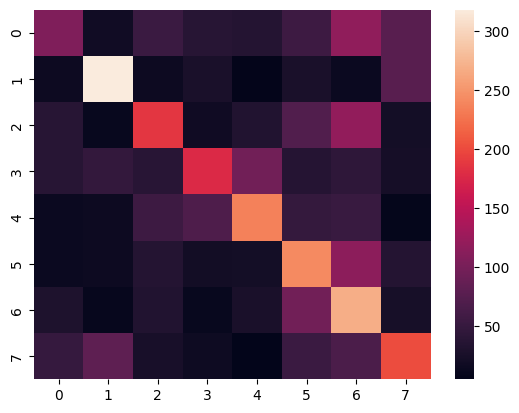

In [24]:
sns.heatmap(conf_matrix)